# Conformalized quantile regression


## Prediction intervals

Suppose we are given $ n $ training samples $ \{(X_i, Y_i)\}_{i=1}^n$ and we must now predict the unknown value of $Y_{n+1}$ at a test point $X_{n+1}$. We assume that all the samples $ \{(X_i,Y_i)\}_{i=1}^{n+1} $ are drawn exchangeably$-$for instance, they may be drawn i.i.d.$-$from an arbitrary joint distribution $P_{XY}$ over the feature vectors $ X\in \mathbb{R}^p $ and response variables $ Y\in \mathbb{R} $. We aim to construct a marginal distribution-free prediction interval $C(X_{n+1}) \subseteq \mathbb{R}$ that is likely to contain the unknown response $Y_{n+1} $. That is, given a desired miscoverage rate $ \alpha $, we ask that
$$ \mathbb{P}\{Y_{n+1} \in C(X_{n+1})\} \geq 1-\alpha $$
for any joint distribution $ P_{XY} $ and any sample size $n$. The probability in this statement is marginal, being taken over all the samples $ \{(X_i, Y_i)\}_{i=1}^{n+1} $.


We start by defining the desired miscoverage rate (10% in our case), and some hyper-parameters of random forests. These parameters are shared by the conditional mean and conditional quantile random forests regression.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')


split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

%matplotlib inline
np.random.seed(1)

# desired miscoverage error
alpha = 0.1

# low and high target quantiles
quantiles = [5, 95]

# maximal number of testpoints to plot
max_show = 1033

# save figures?
save_figures = False

# parameters of random forests
n_estimators = 100
min_samples_leaf = 40
max_features = 1 # 1D signal
random_state = 0

In [10]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import category_encoders as ce

## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df


def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)

    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

def GetDataset(name, base_path):
    """ Load a dataset
    
    Parameters
    ----------
    name : string, dataset name
    base_path : string, e.g. "path/to/datasets/directory/"
    
    Returns
    -------
    X : features (nXp)
    y : labels (n)
    
    """
    
    if name=="library":
        
        #Library
        output_column = 'LE_bowen_corr_mm'
        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                         'Site_6', 'ET_bowen_corr_mm', 'ETo'
                         ]  
        
        df=pd.read_csv(base_path)
        #set output variable between 1 and 15 only
        df = df[df[output_column].between(1, 15)]
        #df.rename(columns_rename, inplace=True)

        #drop desired columns, rename, and drop the nans
        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        #generate lags for columns
        lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
        df = generate_lags(df, lagsForColumns)

        df = binary_encode_column(df, "Site")
        df.drop(columns=['Site_0'], inplace=True)

        #drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
        df.isnull().mean() * 10
        df.dropna(inplace=True)
        print(df.shape)
        print("checking null values in the whole dataset")
        print(df.isnull().values.any())
        print(df.columns)
        #df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
        #df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
        df.dropna(inplace=True)
        X = df.drop(['LE_bowen_corr_mm', "Date"], axis = 1)
        y = df['LE_bowen_corr_mm']

    
    return X, y, df


def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    print(x.shape)
    x_ = x[:max_show]
    print(x_.shape)
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
#     inds = np.argsort(np.squeeze(x_))
    plt.plot(x_, y_, 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_, x_[::-1]]),
                 np.concatenate([y_u_, y_l_[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_, pred_[:,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_, pred_[:,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_, pred_, 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

## Generate synthetic data

Here we generate our training and test samples $(X_i,Y_i)$. To generate the training data, we draw $n=2000$ independent, univariate predictor samples $X_i$ from the uniform distribution on the interval $[1,5]$. The response variable is then sampled as $$ Y_i \sim \textrm{Pois}(\sin^2(X_i) + 0.1) + 0.03 X_i \epsilon_{1,i} + 25 \mathbb{1}\{ U_i < 0.01 \} \epsilon_{2,i},$$ where $\textrm{Pois}(\lambda)$ is the Poisson distribution with mean $\lambda$, both $\epsilon_{1,i}$ and $\epsilon_{2,i}$ are i.i.d.\ standard Gaussian noise, and the $U_i$ are uniform on the interval $[0,1]$. The last term in the equation above creates a few but large outliers. We generate a test set of 5000 samples in the same way.

In [11]:
# name of dataset
dataset_base_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
dataset_name = "library"
test_ratio = 0.2
output_column = "LE_bowen_corr_mm"
# load the dataset
X, y, df = GetDataset(dataset_name, dataset_base_path)

# divide the dataset into test and train based on the test_ratio parameter
x_train, x_test, y_train, y_test = split_train_test_valid(df, 1-test_ratio, test_ratio)

columnToDrop = ["Site", "Date"]
x_train.drop(columnToDrop, axis = 1, inplace=True)
x_test.drop(columnToDrop, axis = 1, inplace=True)
df.drop(columnToDrop, axis = 1, inplace=True)

# reshape the data
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_train.shape)

# compute input dimensions
n_train = x_train.shape[0]
n_test = x_test.shape[0]

(5123, 51)
checking null values in the whole dataset
False
Index(['Date', 'Site', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm',
       'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3',
       'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1',
       'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5',
       'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5', 'Site_1',
       'Site_2', 'Site_3', 'Site_4', 'Site_5'],
      dtype='object')
Number of sites: 24
(4090, 48)


The heteroskedasticity of the data is evident, as the dispersion of $Y$ varies considerably with $X$. The data also contains outliers.

## CQR: Conformalized quantile regression

We begin by splitting the data into a proper training set, indexed by $I_1$, and a calibration set, indexed by $I_2$. 

In [12]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
# n_half = int(np.floor(n_train/2))
n_half = x_train.shape[0] - x_test.shape[0]
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

Given any quantile regression algorithm $\mathcal{A}$ (the function `QuantileForestRegressorAdapter` in the code below), we then fit two conditional quantile functions $\hat{q}_{\alpha_{lo}}$ and $\hat{q}_{\alpha_{hi}}$ on the proper training set: $$ \{ \hat{q}_{\alpha_{lo}}, \hat{q}_{\alpha_{hi}} \} \leftarrow \mathcal{A}(\left\lbrace (X_i, Y_i): i \in I_1 \right\rbrace). $$
This is done by calling the function `icp.fit`.

In the essential next step, the function `icp.calibrate` computes conformity scores (using `QuantileRegErrFunc`) that quantify the error made by the plug-in prediction interval $ \hat{C}(x) = [\hat{q}_{\alpha_{lo}}(x), \ \hat{q}_{\alpha_{hi}}(x)]  $. The scores are evaluated on the calibration set as
$$
	E_i := \max\{\hat{q}_{\alpha_{lo}}(X_i) - Y_i, Y_i - \hat{q}_{\alpha_{hi}}(X_i)\},
$$
for each $i \in I_2$. The conformity score $E_i$ has the following interpretation. If $Y_i$ is below the lower endpoint of the interval, $Y_i < \hat{q}_{\alpha_{lo}}(X_i)$, then $E_i = |Y_i - \hat{q}_{\alpha_{lo}}(X_i)|$ is the magnitude of the error incurred by this mistake. Similarly, if $Y_i$ is above the upper endpoint of the interval, $Y_i > \hat{q}_{\alpha_{hi}}(X_i)$, then $E_i = |Y_i - \hat{q}_{\alpha_{hi}}(X_i)|$. Finally, if $Y_i$ correctly belongs to the interval, $\hat{q}_{\alpha_{lo}}(X_i) \leq Y_i \leq \hat{q}_{\alpha_{hi}}(X_i)$, then $E_i$ is the larger of the two non-positive numbers $\hat{q}_{\alpha_{lo}}(X_i) - Y_i$ and $Y_i - \hat{q}_{\alpha_{hi}}(X_i)$ and so is itself non-positive. The conformity score thus accounts for both undercoverage and overcoverage.

Finally, given new input data $X_{n+1}$, we construct the prediction interval for $Y_{n+1}$ as
$$
C(X_{n+1}) = \left[ \hat{q}_{\alpha_{lo}}(X_{n+1}) - Q_{1-\alpha}(E, I_2) , \ \hat{q}_{\alpha_{hi}}(X_{n+1}) + Q_{1-\alpha}(E, I_2) \right],
$$
where 
$$
Q_{1-\alpha}(E, I_2) :=  (1-\alpha)(1+1/|I_2|)\text{-th empirical quantile of} \left\{E_i : i \in I_2\right\}
$$
conformalizes the plug-in prediction interval. This is done by calling the function `icp.predict`.

This is shape of x train (3057, 48)
This is shape of x calibration (1033, 48)
(2, 1033) error dist shape
(1033, 2) prediction dist shape
(1033, 48)
(1033, 48)


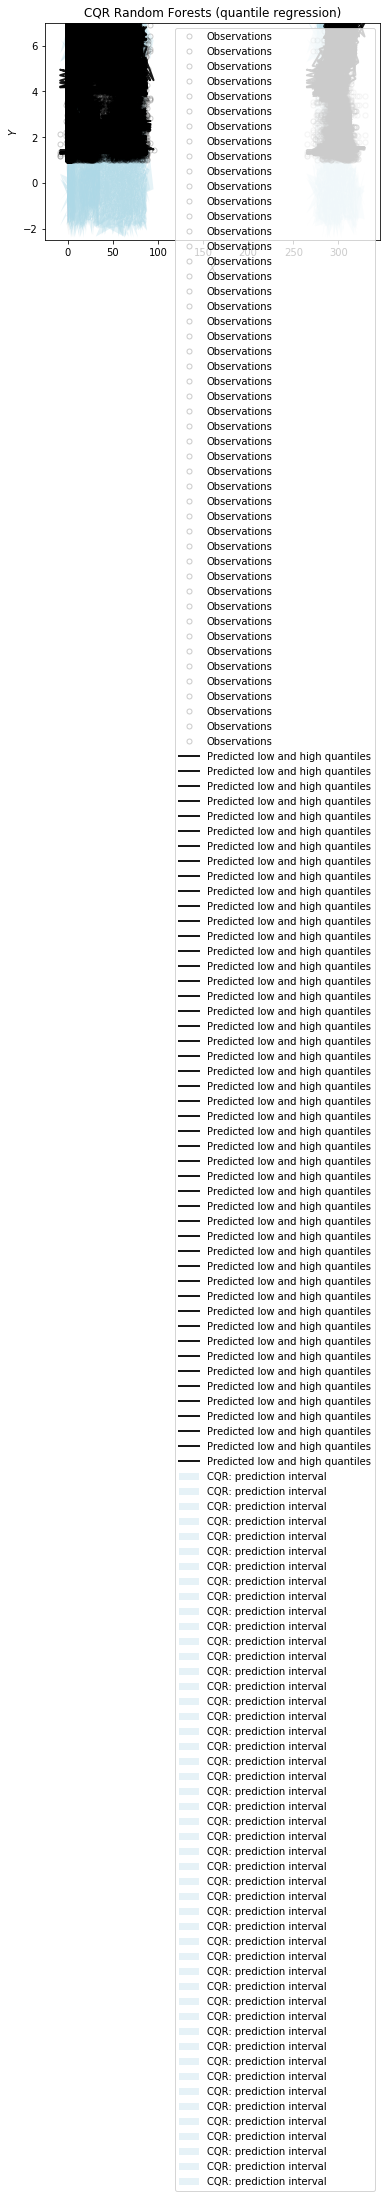

CQR Random Forests: Percentage in the range (expecting 90.0%): 914.0861568247822
CQR Random Forests: Average length: 7.738226052297352


In [14]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = random_state
params_qforest["range_vals"] = 10
params_qforest["num_vals"] = 4

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])
print("This is shape of x train " + str(x_train[idx_train].shape))

# compute the absolute errors on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])
print("This is shape of x calibration " + str(x_train[idx_cal].shape))

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred = quantile_estimator.predict(x_test)

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test))

# compute length of the conformal interval per each test point
length_cqr_rf = y_upper - y_lower

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

The figure above shows two black curves, representing the lower and upper quantile regression estimates based on quantile random forests. The highlighted region visualizes the constructed prediction intervals obtained by CQR. As can be seen, our method obtained valid prediction interval. Notice how the length of constructed interval varies with $X$, reflecting the uncertainty in the prediction of $ Y $.

We now turn to compare the efficiency (average length) of our CQR method to the split conformal and its locally adaptive variant.

## Split conformal

In this section we implement the usual split conformal method. Specifically, we use the proper training and calibration subsets; train a random forest regressor on the first set, and calibrate the intervals on the second set by computing the absolute residual error. Notice that the random forests regressor **estimates the conditional mean** of $Y_i$ given $X_i=x$.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from nonconformist.nc import RegressorNormalizer
from nonconformist.nc import AbsErrorErrFunc

# define the conditonal mean estimator as random forests
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=random_state)

# define a conformal prediction object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc())

# build a regualr split conformal prediction object 
icp = IcpRegressor(nc)

# fit the conditional mean regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=split_color,
          method_name="Split:",title="Random Forests (mean regression)",
          filename="illustration_split_rf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_split_rf = y_upper - y_lower

# compute and display the average length
print("Random Forests: Average length:", np.mean(length_split_rf))

IndexError: index 106708 is out of bounds for axis 0 with size 1033

As can be seen, the prediction interval constructed by the split conformal achieves valid coverage. Notice that the average length of the constructed interval is greater than the one obtained by CQR.

This experiment reveals a major limitation of the split conformal $-$ the length of the interval constructed by the split conformal is fixed and independent of $X$.

## Local conformal

In this section we implement a well-known variant of the locally weighted split conformal method [3], aiming at constructing adaptive intervals. As in the usual split conformal, this method fits a **conditional mean regression function** to the proper training set (formulated as random forest regressor). In the next step, the locally weighted method fits another (second conditional mean regressor) random forests model to the absolute residuals of the proper training set (MAD estimator), this in order to scale the future test residuals. Just as before, the calibration set is used to construct the conformal interval.

In [16]:
# define the conditonal mean estimator as random forests (used to predict the labels)
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=random_state)

# define the MAD estimator as random forests (used to scale the absolute residuals)
mad_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=random_state)

# define a conformal normalizer object that uses the two regression functions.
# The nonconformity score is absolute residual error
normalizer = RegressorNormalizer(mean_estimator,
                                 mad_estimator,
                                 AbsErrorErrFunc())

# define the final local conformal object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc(), normalizer)

# build the split local conformal object
icp = IcpRegressor(nc)

# fit the conditional mean and MAD models to proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)

# extract the lower and upper bound of the prediction interval
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=local_color,
          method_name="Local:",title="Random Forests Local (mean regression)",
          filename="illustration_split_local_rf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Local Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_local_rf = y_upper - y_lower

# compute and display the average length
print("Local Random Forests: Average length:", np.mean(length_local_rf))

ValueError: operands could not be broadcast together with shapes (1033,1033) (1033,3057) 

The prediction intervals constructed by the local split conformal also achieves valid coverage. The intervals are partially adaptive, resulting in slightly shorter intervals than the usual split conformal, but inferior than the ones obtained by CQR.

We compare the efficiency of the three methods in the following figure, displaying the length of the interval as a function of $X$.

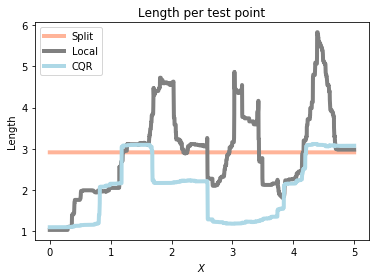

In [8]:
fig = plt.figure()
inds = np.argsort(np.squeeze(x_test))

plt.plot(x_test[inds,:], length_split_rf[inds], "orangered", alpha=.4, lw=4, label=u'Split')
plt.plot(x_test[inds,:], length_local_rf[inds], local_color, lw=4, label=u'Local')
plt.plot(x_test[inds,:], length_cqr_rf[inds], cqr_color, lw=4, label=u'CQR')

plt.xlabel('$X$')
plt.ylabel('Length')
plt.legend(loc='upper left')
plt.title('Length per test point')
if save_figures:
    plt.savefig("illustration_length.png", bbox_inches='tight', dpi=300)
plt.show()

## Local conformal with median regression

To improve robustness to outliers, one might try to estimate the conditional median instead of the conditional mean in locally adaptive conformal prediction. The residuals are scaled in the usual way, by classical regression via random forests. We implement this strategy in the following section.

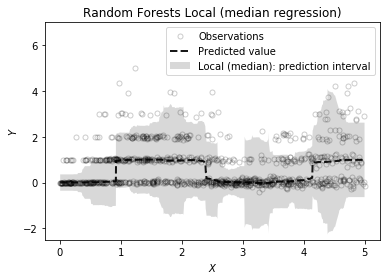

Local Median Random Forests: Percentage in the range (expecting 90.0%): 90.14
Local Median Random Forests: Average length: 2.8626194525789557


In [9]:
from skgarden import RandomForestQuantileRegressor
from nonconformist.base import RegressorAdapter

# replace conditional mean by conditional median estimator
class MedianRegressorAdapter(RegressorAdapter):
    """ Conditional median estimator, defined as quantile random forests (QRF)
    
    References
    ----------
    .. [1]  Meinshausen, Nicolai. "Quantile regression forests."
            Journal of Machine Learning Research 7.Jun (2006): 983-999.
                
    """
    def __init__(self, model, fit_params=None, quantiles=[50], params=None):
        super(MedianRegressorAdapter, self).__init__(model, fit_params)
        # Instantiate model
        self.quantiles = quantiles
        self.cv_quantiles = self.quantiles
        self.params = params
        self.rfqr = RandomForestQuantileRegressor(random_state=params["random_state"],
                                                  min_samples_leaf=params["min_samples_leaf"],
                                                  n_estimators=params["n_estimators"],
                                                  max_features=params["max_features"])
        
    def fit(self, x, y):
        self.rfqr.fit(x, y)
    
    def predict(self, x):
        return self.rfqr.predict(x, quantile=50)

# define the conditional median model as random forests regressor (used to predict the labels)
median_estimator = MedianRegressorAdapter(model=None,
                                          fit_params=None,
                                          quantiles=[50],
                                          params=params_qforest)

# define the MAD estimator as usual (mean) random forests regressor (used to scale the absolute residuals)
mad_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=random_state)

# define a conformal normalizer object that uses the two regression functions.
# The nonconformity score is absolute residual error
normalizer = RegressorNormalizer(median_estimator,
                                 mad_estimator,
                                 AbsErrorErrFunc())

# define the final local conformal object 
nc = RegressorNc(median_estimator, AbsErrorErrFunc(), normalizer)

# build the split local conformal object
icp = IcpRegressor(nc)

# fit the conditional mean and usual MAD models to proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional median estimation
pred = median_estimator.predict(x_test)

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=local_color,
          method_name="Local (median):",title="Random Forests Local (median regression)",
          filename="illustration_split_local_median_rf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Local Median Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute and display the average length
print("Local Median Random Forests: Average length:", np.mean(y_upper - y_lower))

At least on this simulated dataset, estimating conditional medians instead of means has little effect on the average lengths of the prediction intervals (compare the efficiency of this approach to the locally weighted split conformal).

## Summary

We illustrated how to deploy the proposed CQR procedure to construct valid prediction intervals. This experiment compares CQR to two competitive methods $-$ split conformal and its locally weighted alternative. CQR outperforms both methods in terms of the efficiency and adaptivity of the intervals.